In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import *
sns.set()
import findspark
findspark.init()
import pyspark
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
from pyspark.sql import *
from pyspark.sql.functions import *
import re

import warnings
warnings.filterwarnings('ignore')

# Sugar is linked to health issues, but so are fats and salts. Do sugary products also tend to contain more fat/salt or not?

* Grab all products sugar and fat and salt
* Analyse correlation.
* Break down into categories?

In [2]:
#Load the data
df = spark.read\
    .format("csv")\
    .option("header", "true")\
    .option("delimiter", "\t")\
    .load('./data/en.openfoodfacts.org.products.csv')

In [35]:
#Allow SQL queries to be executed
df.createOrReplaceTempView("df_view")

#Obtain all products that has a list of categories defined
sqlDF = spark.sql("SELECT product_name, sugars_100g, fat_100g, salt_100g, energy_100g, serving_quantity \
                  FROM df_view \
                  WHERE \
                  sugars_100g IS NOT NULL AND sugars_100g <= 100 AND sugars_100g >= 0 AND \
                  fat_100g IS NOT NULL    AND fat_100g <= 100    AND fat_100g >= 0 AND \
                  salt_100g IS NOT NULL   AND salt_100g <= 100   AND salt_100g >= 0")

In [36]:
#Convert it into a dataframe
data = sqlDF.toPandas()

#Correct the Dtypes
data['sugars_100g'] = data['sugars_100g'].astype(float)
data['fat_100g'] = data['fat_100g'].astype(float)
data['salt_100g'] = data['salt_100g'].astype(float)

#Select what information to have a look at
nutrition = data[['sugars_100g', 'fat_100g', 'salt_100g']]
#nutrition = nutrition.head(10000)

Restricting the amounts to valid ranges reduced the amount of objects from 560974 to 560447, so around one in a thousand items are wrongly labeled.

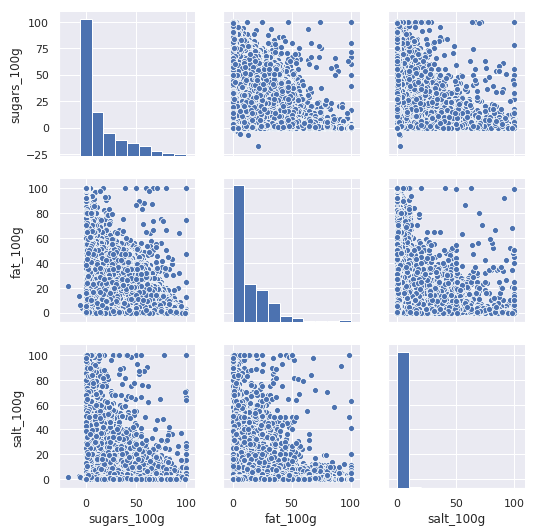

In [28]:
sns.pairplot(data=nutrition)

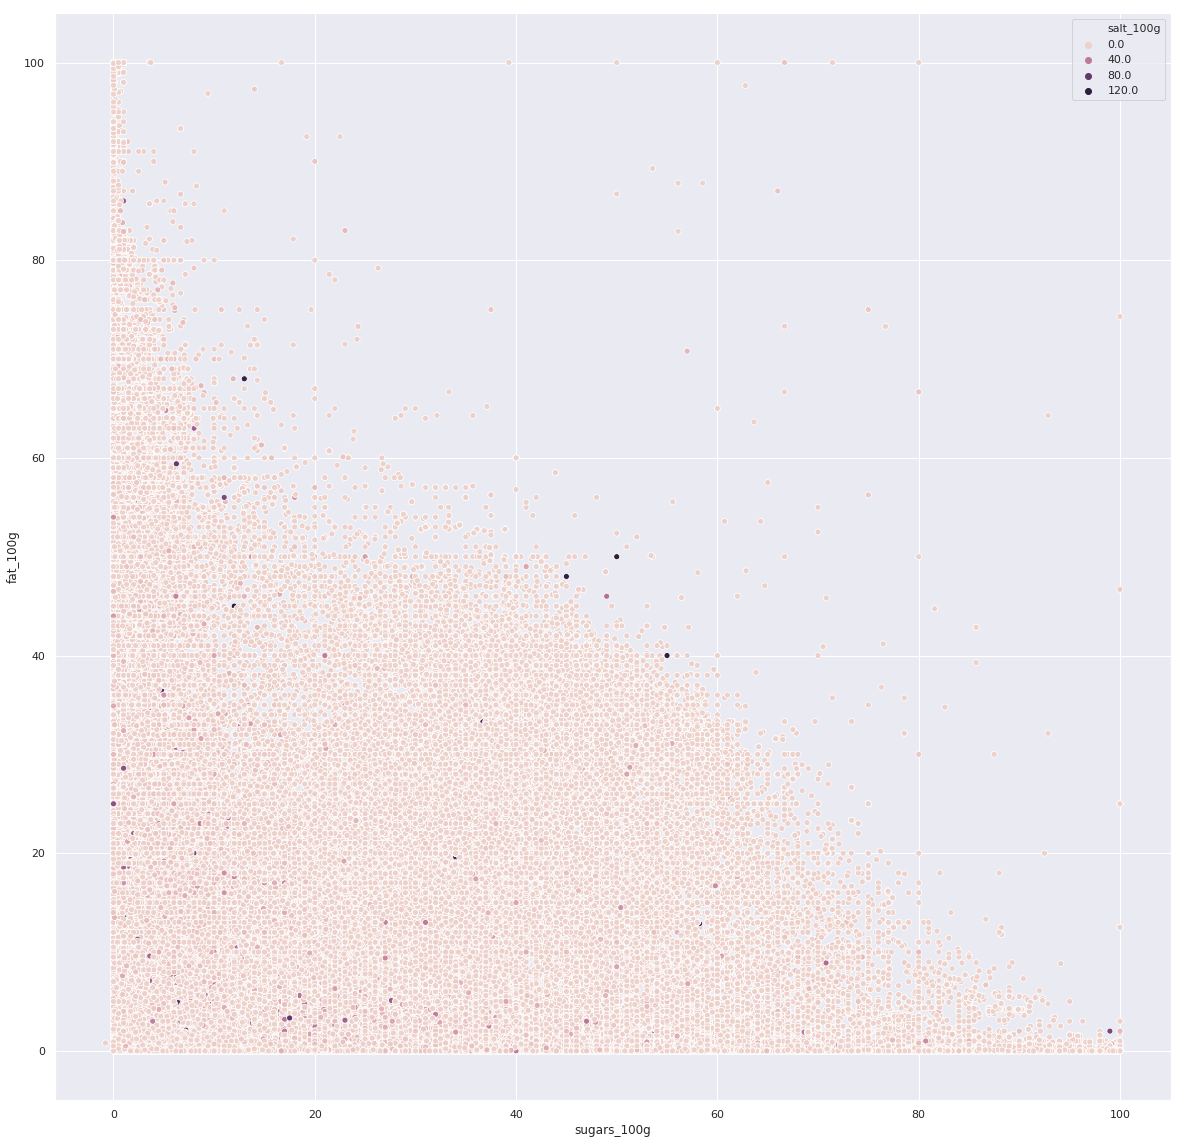

In [41]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20) )
sns.scatterplot(x="sugars_100g", y="fat_100g",hue='salt_100g', data=nutrition)

# It is often said that cheap and sugary go hand in hand. Is there any correlation between sugar content in low-price brands and high price brands?
* Identify low-cost brands and "high price" (normal?) brands
* Seperate them. Ensure no overlap.
* Analyse correlation

In [43]:
#Allow SQL queries to be executed
df.createOrReplaceTempView("df_view")

#Obtain all products that has a list of categories defined
sqlDF = spark.sql("SELECT product_name, brands_tags, sugars_100g \
                  FROM df_view \
                  WHERE brands_tags IS NOT NULL")

#Convert it into a dataframe
brands_df = sqlDF.toPandas()

In [44]:
# Define the brands we are interested in. For now, we only look at division in the migros and coop sortiment.
m1 = 'migros'
m2 = 'm-classic'
m3 = 'm-budget'
m4 = 'terrasuisse'
m5 = 'frey'
m6 = 'migros-bio'

c1 = 'coop'
c2 = 'coop-prix-garantie'
c3 = 'coop-naturaplan'
c4 = 'coop-naturaplan-bio'

# Order them into categories we are interested in

m_brands = [m1, m2, m3, m4, m5, m6]

c_brands = [c1, c2, c3, c4]

low_cost_brands = [m3, c2]

bio_brands = [m6, c3, c4]

normal_brands = [m1, m2, c1]

In [49]:
def to_regex(brands):
    """
    Convenience function that formats a list of brands into regex for the brands
    """
    pattern = "(,|^)("
    for brand in brands:
        pattern += brand + "|"
        
    pattern = pattern[:-1]
    pattern  = pattern + ")(,|$)"
    return pattern

In [50]:
#For each set of brands, obtain the dataframes
pattern = to_regex(normal_brands)
NORMAL_pd = brands_df.loc[brands_df['brands_tags'].str.contains(pattern, flags=re.IGNORECASE, regex=True)]

pattern = to_regex(low_cost_brands)
LOCOST_pd = brands_df.loc[brands_df['brands_tags'].str.contains(pattern, flags=re.IGNORECASE, regex=True)]

pattern = to_regex(bio_brands)
BIO_pd = brands_df.loc[brands_df['brands_tags'].str.contains(pattern, flags=re.IGNORECASE, regex=True)]

In [51]:
#For each set of brands, group the amount of products by sugar content and pretty up the dataframe
locost = LOCOST_pd[['sugars_100g', 'brands_tags']].groupby('sugars_100g').count()
locost = locost.rename(columns={'brands_tags': 'products'})
locost = locost.reset_index()

bio = BIO_pd[['sugars_100g', 'brands_tags']].groupby('sugars_100g').count()
bio = bio.rename(columns={'brands_tags': 'products'})
bio = bio.reset_index()

norm = NORMAL_pd[['sugars_100g', 'brands_tags']].groupby('sugars_100g').count()
norm = norm.rename(columns={'brands_tags': 'products'})
norm = norm.reset_index()

#The sugar values seemed to be a mix of strings, ints and floats, so we convert them to a common dtype
locost[['sugars_100g']] = locost[['sugars_100g']].astype(float)
bio[['sugars_100g']] = bio[['sugars_100g']].astype(float)
norm[['sugars_100g']] = norm[['sugars_100g']].astype(float)


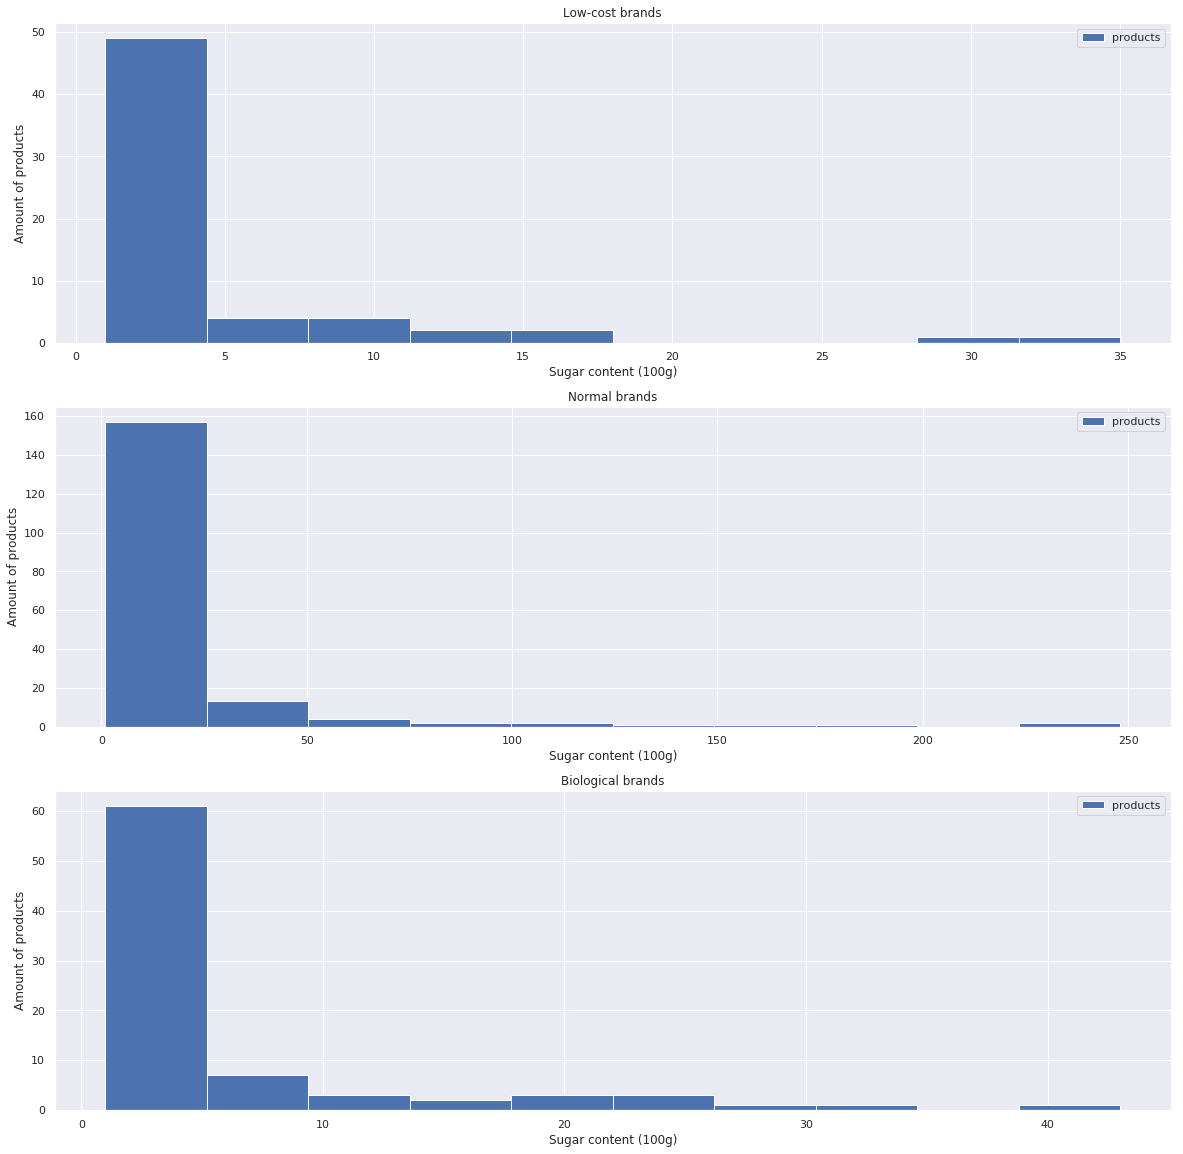

In [52]:
#Plot the distributions
fig, axs = plt.subplots(3, 1, figsize=(20, 20) )
locost.plot(x='sugars_100g', y = 'products', ax=axs[0], kind='hist')
axs[0].set_xlabel("Sugar content (100g)")
axs[0].set_ylabel("Amount of products")
axs[0].set_title('Low-cost brands')

norm.plot(x='sugars_100g', y = 'products', ax=axs[1], kind='hist')
axs[1].set_xlabel("Sugar content (100g)")
axs[1].set_ylabel("Amount of products")
axs[1].set_title('Normal brands')

bio.plot(x='sugars_100g', y = 'products', ax=axs[2], kind='hist')
axs[2].set_xlabel("Sugar content (100g)")
axs[2].set_ylabel("Amount of products")
axs[2].set_title('Biological brands')
plt.show()
